 **Our main objective here is to do Mob Price Range Prediction.**

In [2]:
#importing necessary libraries
import numpy as np
import pandas as pd    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve,auc,classification_report,confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score,f1_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from matplotlib_venn import venn3,venn3_circles
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)

In [4]:
#reading csv file into dataframe
df = pd.read_csv('data_mobile_price_range.csv')

In [5]:
#rows and columns of dataframe
df.shape

(2000, 21)

In [6]:
#sample of dataset
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,2,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,6,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,6,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,9,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,14,1208,1212,1411,8,2,15,1,1,0,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

**There are no missing values in the data-set.**

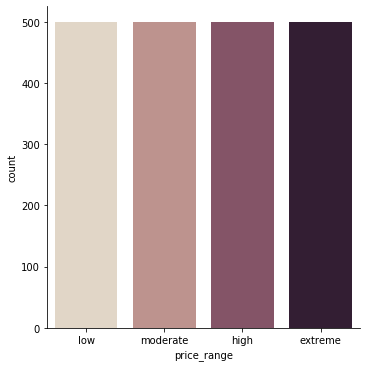

In [8]:
sns.catplot(x="price_range", kind="count", palette="ch:.25", data=df)
plt.xticks(ticks=[0,1,2,3],labels = ['low','moderate','high','extreme'])
plt.show()

**This seems to be a multi-class classification problem with 4 classes.**

**This seems like a balanced dataset, so no need for handling class imbalance.**

In [9]:
df.columns

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi', 'price_range'], dtype='object')

In [10]:
df.columns = ['battery_power', 'bluetooth', 'clock_speed', 'dual_sim', 'front_cam', '4G', 'ROM',
              'depth', 'weight', 'cores', 'rear_cam', 'resol_height', 'resol_width', 'RAM', 'height', 
              'width', 'talk_time', '3G', 'touch_screen', 'wifi', 'price_range']

In [11]:
print('\033[1m' + 'Column \t\t No.of unique values')
print('\033[0m')
for i in df:
    print(i,' '*(13-len(i)),'\t',df[i].nunique())

Column 		 No.of unique values

battery_power  	 1094
bluetooth      	 2
clock_speed    	 26
dual_sim       	 2
front_cam      	 20
4G             	 2
ROM            	 63
depth          	 10
weight         	 121
cores          	 8
rear_cam       	 21
resol_height   	 1137
resol_width    	 1109
RAM            	 1562
height         	 15
width          	 19
talk_time      	 19
3G             	 2
touch_screen   	 2
wifi           	 2
price_range    	 4


# Identifying the categorical and numerical features.

In [12]:
dependent = 'price_range'
independent = list(set(df.columns) - {dependent})
categorical = []
print('\033[1m' + 'Categorical Variables\t\tUnique Values' + '\033[0m')
for i in independent:
    if df[i].nunique()<10:
        categorical.append(i)
        print(i,' '*(12-len(i)),'\t\t\t',df[i].unique())
numerical = list(set(df.columns) - set(categorical)- {dependent})

Categorical Variables		Unique Values
touch_screen  			 [0 1]
bluetooth     			 [0 1]
wifi          			 [1 0]
4G            			 [0 1]
3G            			 [0 1]
cores         			 [2 3 5 6 1 8 4 7]
dual_sim      			 [0 1]


In [13]:
df.describe()

,battery_power,bluetooth,clock_speed,dual_sim,front_cam,4G,ROM,depth,weight,cores,rear_cam,resol_height,resol_width,RAM,height,width,talk_time,3G,touch_screen,wifi,price_range
count,2000.000000,2000.0000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,0.4950,1.522250,0.509500,4.309500,0.521500,32.046500,0.501750,140.249000,4.520500,9.916500,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000,0.761500,0.503000,0.507000,1.500000
std,439.418206,0.5001,0.816004,0.500035,4.341444,0.499662,18.145715,0.288416,35.399655,2.287837,6.064315,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955,0.426273,0.500116,0.500076,1.118314
min,501.000000,0.0000,0.500000,0.000000,0.000000,0.000000,2.000000,0.100000,80.000000,1.000000,0.000000,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,851.750000,0.0000,0.700000,0.000000,1.000000,0.000000,16.000000,0.200000,109.000000,3.000000,5.000000,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000,1.000000,0.000000,0.000000,0.750000
50%,1226.000000,0.0000,1.500000,1.000000,3.000000,1.000000,32.000000,0.500000,141.000000,4.000000,10.000000,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000,1.000000,1.000000,1.000000,1.500000
75%,1615.250000,1.0000,2.200000,1.000000,7.000000,1.000000,48.000000,0.800000,170.000000,7.000000,15.000000,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000,1.000000,1.000000,1.000000,2.250000
max,1998.000000,1.0000,3.000000,1.000000,19.000000,1.000000,64.000000,1.000000,200.000000,8.000000,20.000000,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000,1.000000,1.000000,1.000000,3.000000


# Data Cleaning

**Some Values seem to be fishy.**

**The sc_w(Screen Width) column has 180 values which are 0.**

In [14]:
df[df['width']==0].shape[0]

180

In [15]:
df[df['resol_height']==0].shape[0]

2

In [16]:
df = df[df['resol_height']!=0]

## Making these values which are zero as nan.

In [17]:
df['width'] = df['width'].replace(0, np.nan)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1998 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  1998 non-null   int64  
 1   bluetooth      1998 non-null   int64  
 2   clock_speed    1998 non-null   float64
 3   dual_sim       1998 non-null   int64  
 4   front_cam      1998 non-null   int64  
 5   4G             1998 non-null   int64  
 6   ROM            1998 non-null   int64  
 7   depth          1998 non-null   float64
 8   weight         1998 non-null   int64  
 9   cores          1998 non-null   int64  
 10  rear_cam       1998 non-null   int64  
 11  resol_height   1998 non-null   int64  
 12  resol_width    1998 non-null   int64  
 13  RAM            1998 non-null   int64  
 14  height         1998 non-null   int64  
 15  width          1819 non-null   float64
 16  talk_time      1998 non-null   int64  
 17  3G             1998 non-null   int64  
 18  touch_sc

## Using KNN Imputer to fill appropriate values in the width column.

In [19]:
from sklearn.impute import KNNImputer

In [20]:
imputer = KNNImputer(n_neighbors=1)

In [21]:
df = pd.DataFrame(imputer.fit_transform(df),columns=df.columns)

In [22]:
df.shape

(1998, 21)

In [23]:
df.head()

,battery_power,bluetooth,clock_speed,dual_sim,front_cam,4G,ROM,depth,weight,cores,rear_cam,resol_height,resol_width,RAM,height,width,talk_time,3G,touch_screen,wifi,price_range
0,842.0,0.0,2.2,0.0,1.0,0.0,7.0,0.6,188.0,2.0,2.0,20.0,756.0,2549.0,9.0,7.0,19.0,0.0,0.0,1.0,1.0
1,1021.0,1.0,0.5,1.0,0.0,1.0,53.0,0.7,136.0,3.0,6.0,905.0,1988.0,2631.0,17.0,3.0,7.0,1.0,1.0,0.0,2.0
2,563.0,1.0,0.5,1.0,2.0,1.0,41.0,0.9,145.0,5.0,6.0,1263.0,1716.0,2603.0,11.0,2.0,9.0,1.0,1.0,0.0,2.0
3,615.0,1.0,2.5,0.0,0.0,0.0,10.0,0.8,131.0,6.0,9.0,1216.0,1786.0,2769.0,16.0,8.0,11.0,1.0,0.0,0.0,2.0
4,1821.0,1.0,1.2,0.0,13.0,1.0,44.0,0.6,141.0,2.0,14.0,1208.0,1212.0,1411.0,8.0,2.0,15.0,1.0,1.0,0.0,1.0


**Now our dataset is ready for EDA.**

# Exploratory Data Analysis

**Exploring Numerical Variables.**

In [24]:
numerical

['battery_power',
 'RAM',
 'resol_width',
 'rear_cam',
 'resol_height',
 'talk_time',
 'weight',
 'depth',
 'width',
 'height',
 'front_cam',
 'ROM',
 'clock_speed']

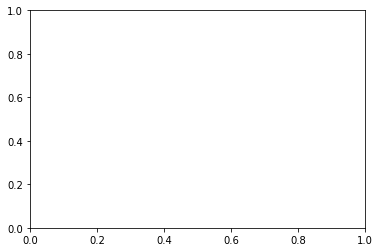

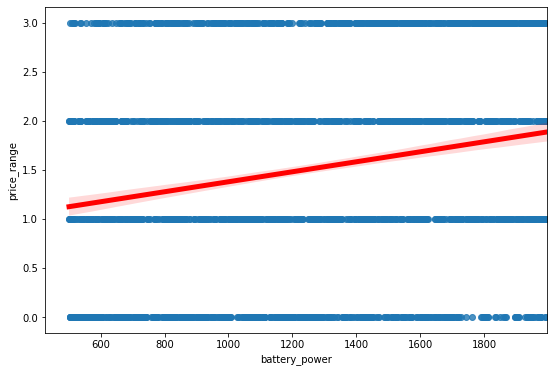

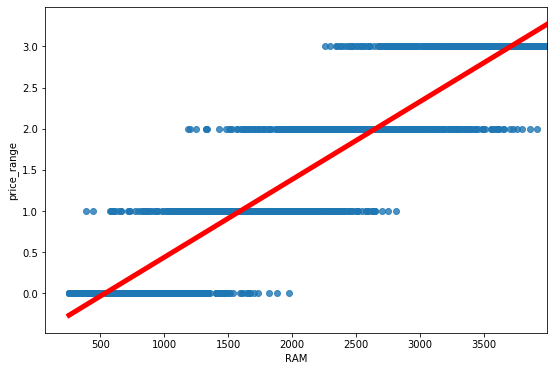

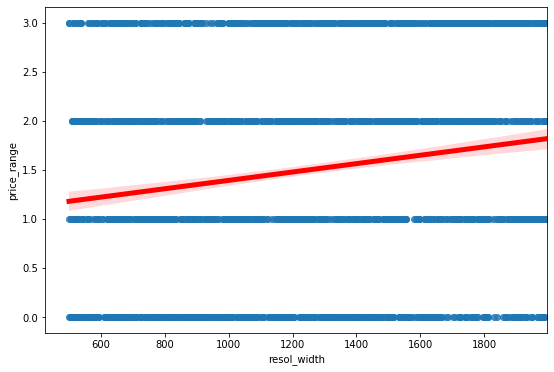

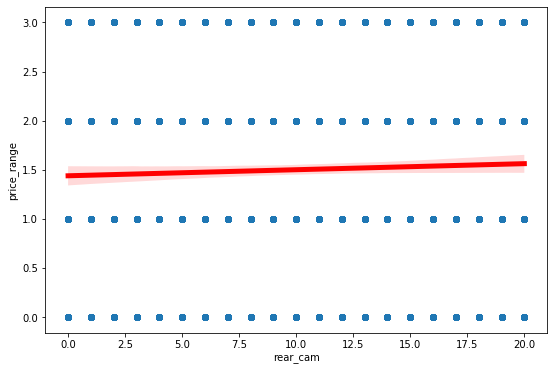

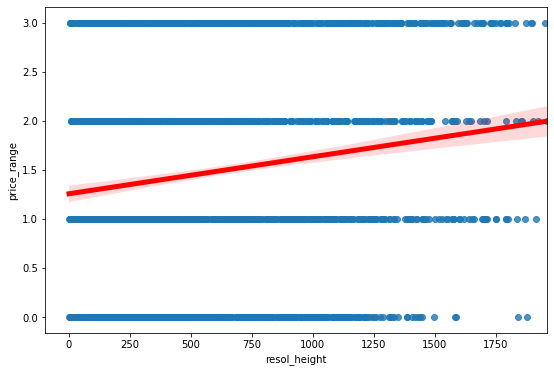

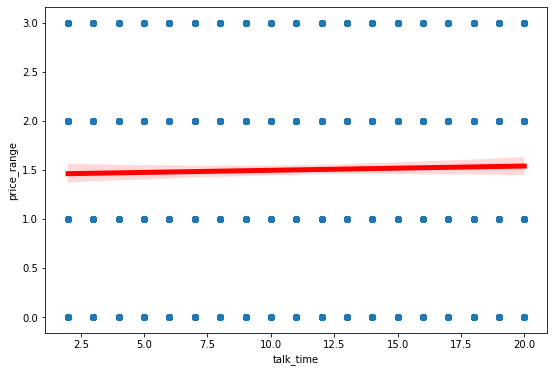

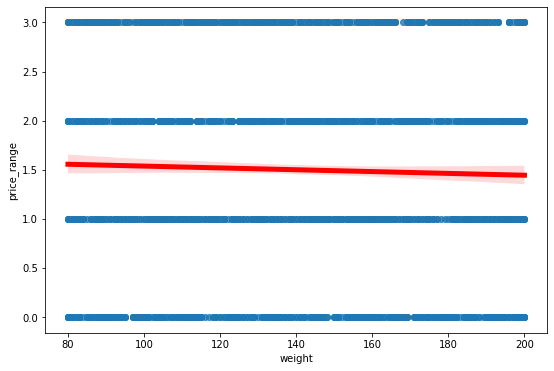

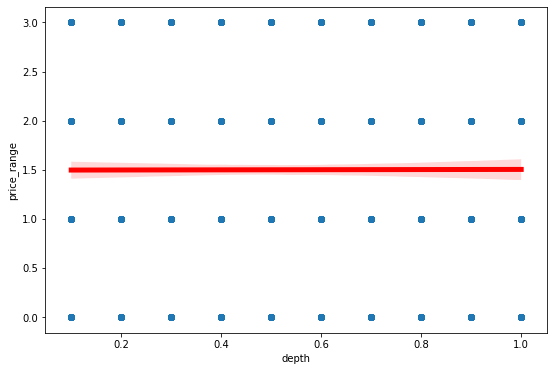

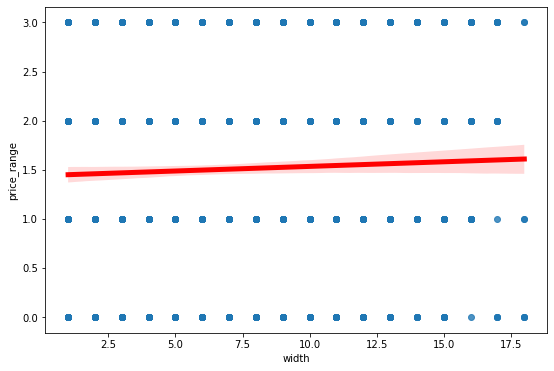

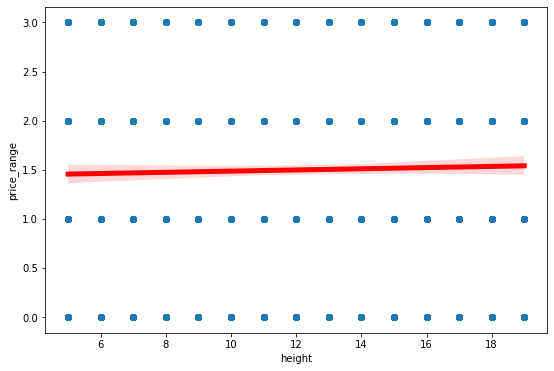

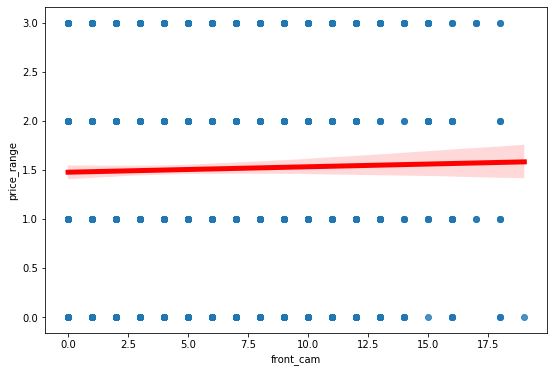

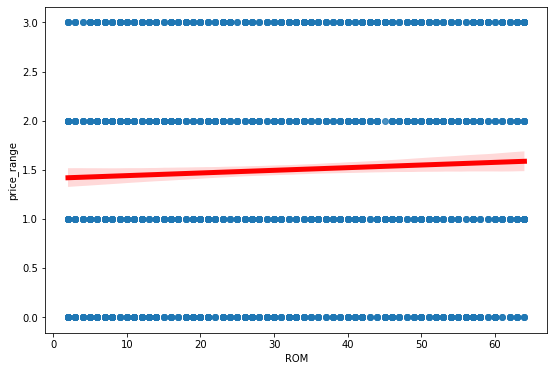

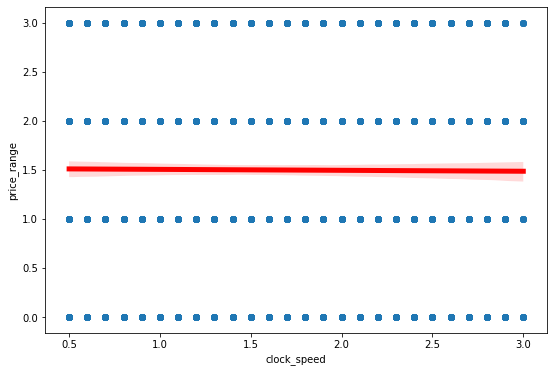

In [25]:
fig,axes = plt.subplots()
for i in numerical:
    fig = plt.figure(figsize=(9, 6))
    sns.regplot(x = i, y = 'price_range', data = df,line_kws={'lw': 5, 'color': 'red'})
    plt.show()



**Exploring Categorical Variables.**

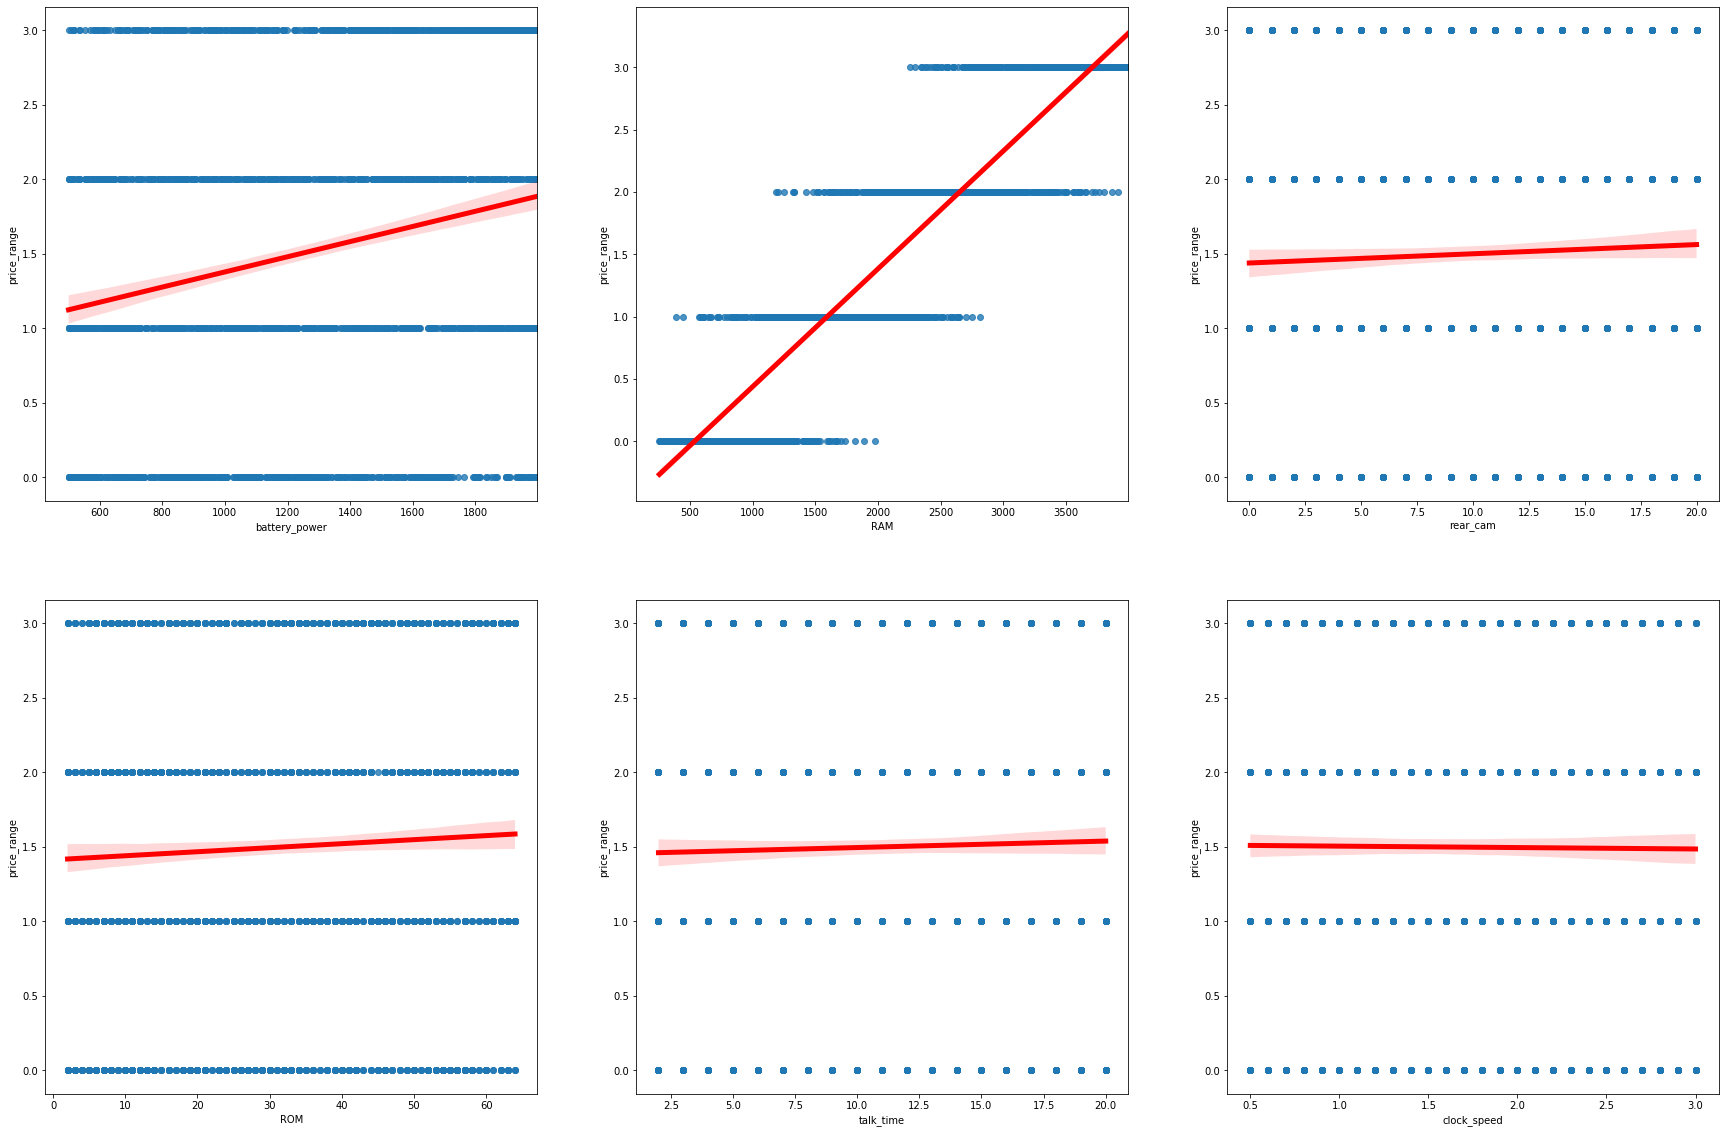

In [26]:
fig, axes = plt.subplots(2, 3,figsize=(30,20))
numerical1 = ['battery_power','RAM','rear_cam','ROM','talk_time','clock_speed']
z=0
for i in range(2):
    for j in range(3):
        plt.sca(axes[i][j])
        sns.regplot(x = numerical1[z], y = 'price_range', data = df,line_kws={'lw': 5, 'color': 'red'})
        z+=1

In [27]:
categorical = ['bluetooth',  'touch_screen', '3G', 'dual_sim', 'wifi', '4G']

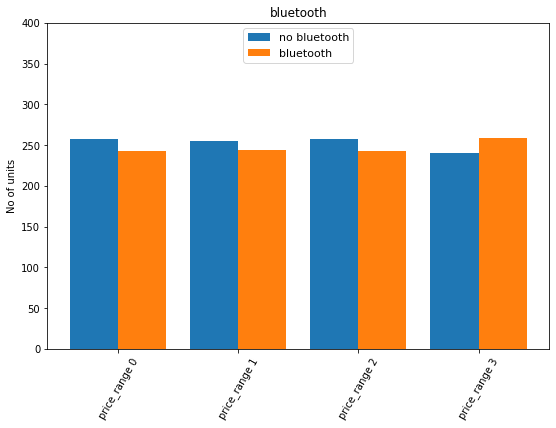

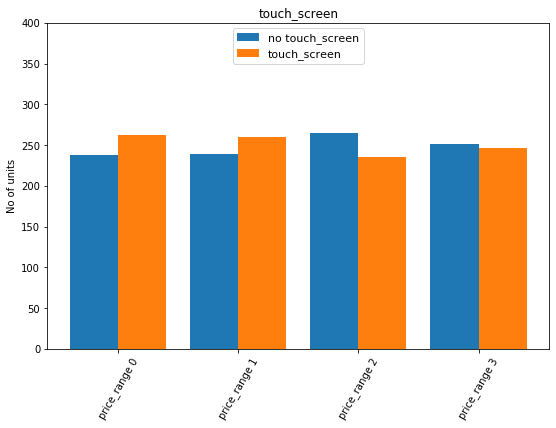

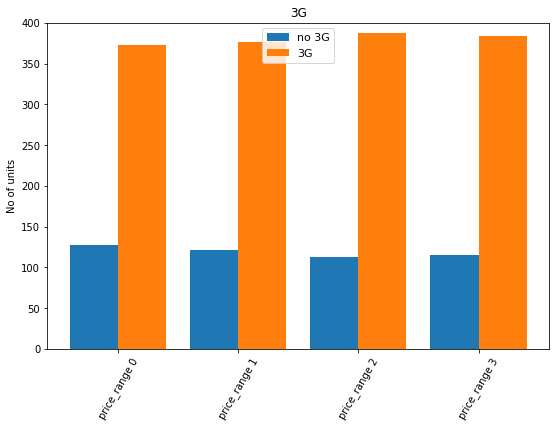

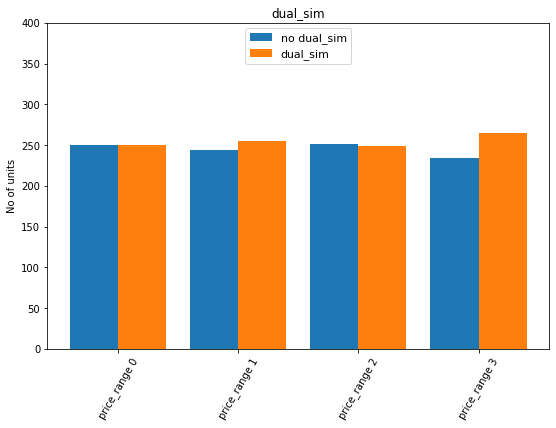

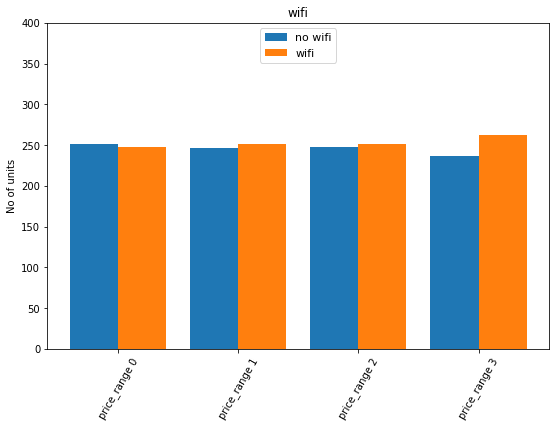

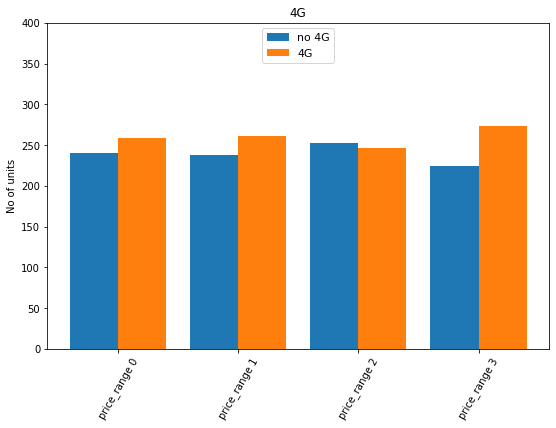

In [28]:
# Creating df according to price_range
df_0 = df[df['price_range'] == 0]
df_1 = df[df['price_range'] == 1]
df_2 = df[df['price_range'] == 2]
df_3 = df[df['price_range'] == 3]


# Creating stacked bar charts for each categorical feature wrt price range
for col in categorical:
    if col!='cores':
      fig = plt.figure(figsize=(9, 6))
      ax = fig.gca()
      plt.bar(x=[-0.2,0.8,1.8,2.8], height = [df_0[col].value_counts().sort_index()[0],df_1[col].value_counts().sort_index()[0],df_2[col].value_counts().sort_index()[0],df_3[col].value_counts().sort_index()[0]],
              label = 'no '+col, width = 0.4)
      plt.bar(x=[0.2,1.2,2.2,3.2], height = [df_0[col].value_counts().sort_index()[1],df_1[col].value_counts().sort_index()[1],df_2[col].value_counts().sort_index()[1],df_3[col].value_counts().sort_index()[1]],
              label = col,width = 0.4)
      plt.title(col)
      plt.legend(fontsize = 11, loc = 'upper center')
      plt.xticks([0,1,2,3],['price_range 0','price_range 1','price_range 2','price_range 3'], rotation = 60)
      plt.ylabel('No of units')
      plt.ylim(0,400)

**Most categorical features do not have much impact on price range.**

**Venn-Diagram of some features.**

In [29]:
def minus(a):
    return len(df[df[a] == 0])
    
def intersect(lst):
    temp = df[df[lst[0]] == 0]
    for i in range (1,len(lst)):
        temp = temp[(temp[lst[i-1]] == 0) & (temp[lst[i]] == 0)]
    return len(temp)

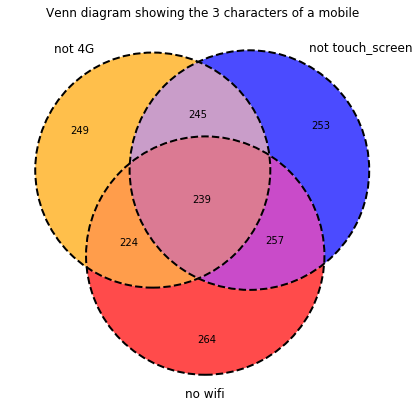

In [30]:
plt.figure(figsize=(25, 7))
abc = intersect(['4G','touch_screen','wifi'])
ab = intersect(['4G','touch_screen']) - abc
bc = intersect(['touch_screen','wifi']) - abc
ca = intersect(['4G','wifi']) - abc
a = minus('4G') - ab - ca - abc
b = minus('touch_screen') - bc - ab - abc
c = minus('wifi') - ca - bc - abc
venn3(subsets=(a, b, ab, c, ca, bc, abc), 
      set_labels=('not 4G', 'not touch_screen', 'no wifi'), 
      set_colors=("orange", "blue", "red"), alpha=0.7)
venn3_circles(subsets=(a, b, ab, c, ca, bc, abc),
              linestyle="dashed", linewidth=2)
plt.title('Venn diagram showing the 3 characters of a mobile')
plt.show()

**Correlation Heatmap**

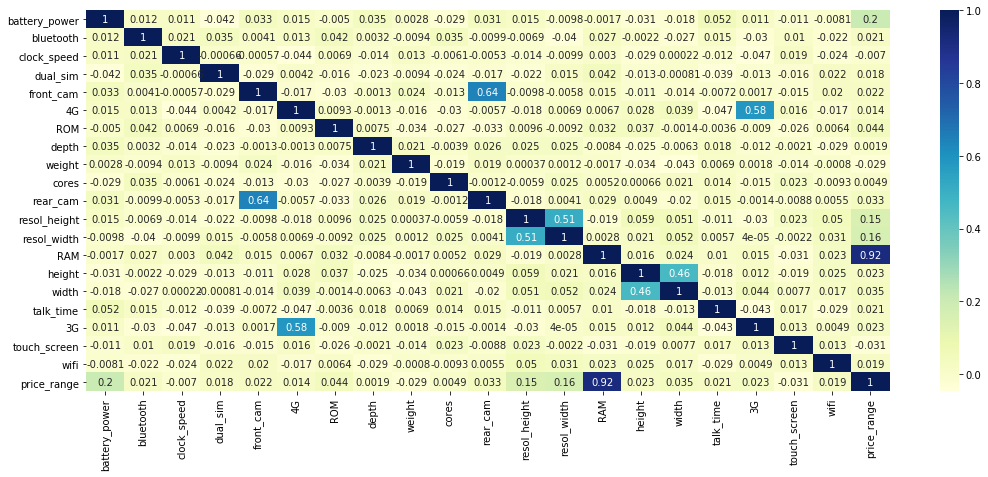

In [32]:
fig, ax = plt.subplots(figsize=(18,7))         # Sample figsize in inches
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.show()

*Here* We can see that some features are correlated. We can do some feature engineering and also remove some variables.

# Data PreProcessing

In [571]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [572]:
calc_vif(df[numerical])

,variables,VIF
0,talk_time,4.800848
1,height,10.805861
2,battery_power,7.912981
3,depth,3.895832
4,resol_width,11.450749
5,resol_height,4.254352
6,clock_speed,4.213391
7,width,4.269708
8,ROM,3.926962
9,front_cam,3.403928


We have to reduce our vifs 

In [573]:
#let us remove the weight column
df.drop(columns = 'weight',inplace=True)
numerical.remove('weight')

In [574]:
calc_vif(df[numerical])

,variables,VIF
0,talk_time,4.688265
1,height,10.369454
2,battery_power,7.518759
3,depth,3.815082
4,resol_width,10.964003
5,resol_height,4.253689
6,clock_speed,4.093750
7,width,4.267947
8,ROM,3.885052
9,front_cam,3.402830


**Making two correlated variables width and height in one single variable.**

In [575]:
#length variable which gives us the diagonal lenght of the mobile
df['length'] = np.round(np.sqrt(df['width']**2 + df['height']**2))
df.drop(columns = ['height','width'],inplace = True)
numerical.append('length')
numerical.remove('width')
numerical.remove('height')

In [576]:
calc_vif(df[numerical])

,variables,VIF
0,talk_time,4.686591
1,battery_power,7.497457
2,depth,3.813416
3,resol_width,10.976364
4,resol_height,4.252511
5,clock_speed,4.092159
6,ROM,3.858055
7,front_cam,3.402049
8,rear_cam,6.130489
9,RAM,4.503590


**Doing the same for resolution width and resolution height.**

In [577]:
df['resol_length'] = np.round(np.sqrt(df['resol_width']**2 + df['resol_height']**2))
df.drop(columns = ['resol_height','resol_width'],inplace = True)
numerical.append('resol_length')
numerical.remove('resol_width')
numerical.remove('resol_height')

In [578]:
calc_vif(df[numerical])

,variables,VIF
0,talk_time,4.668236
1,battery_power,7.480423
2,depth,3.809082
3,clock_speed,4.078104
4,ROM,3.857476
5,front_cam,3.401508
6,rear_cam,6.110185
7,RAM,4.482238
8,length,7.421052
9,resol_length,7.185796


highest Variance inflation factor got reduced to 7

In [579]:
df.head()

,battery_power,bluetooth,clock_speed,dual_sim,front_cam,4G,ROM,depth,cores,rear_cam,RAM,talk_time,3G,touch_screen,wifi,price_range,length,resol_length
0,842.0,0.0,2.2,0.0,1.0,0.0,7.0,0.6,2.0,2.0,2549.0,19.0,0.0,0.0,1.0,1.0,11.0,756.0
1,1021.0,1.0,0.5,1.0,0.0,1.0,53.0,0.7,3.0,6.0,2631.0,7.0,1.0,1.0,0.0,2.0,17.0,2184.0
2,563.0,1.0,0.5,1.0,2.0,1.0,41.0,0.9,5.0,6.0,2603.0,9.0,1.0,1.0,0.0,2.0,11.0,2131.0
3,615.0,1.0,2.5,0.0,0.0,0.0,10.0,0.8,6.0,9.0,2769.0,11.0,1.0,0.0,0.0,2.0,18.0,2161.0
4,1821.0,1.0,1.2,0.0,13.0,1.0,44.0,0.6,2.0,14.0,1411.0,15.0,1.0,1.0,0.0,1.0,8.0,1711.0


# X and Y

In [580]:
independent = list(set(df.columns) - {dependent})

In [581]:
X = df[independent]
y = df[dependent]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Splitting into train and test data

In [582]:
from sklearn.model_selection import train_test_split

## A function which will take a particular algorithm, check if scaling the features is required or not and return the feature importance plot for that algorithm.

In [583]:
def printFeatureImportance(alg,scale=0):
    plt.figure(figsize=(20,9))
    try:
        imp = alg.feature_importances_
    except:
        imp = np.abs(alg.coef_[0])
    if scale:
        some_X = scaler.fit_transform(X)
    else:
        some_X = X
    feat_imp = pd.Series(imp, independent).sort_values(ascending=False)[:5]
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

**Different kind of algoritms we will be using.**

In [33]:
index = ['KNN','Decision Tree','Logistic Regression','Random Forest','AdaBoost','Gradient Boost','XGBoost']

# A function which will compare the results from the same algorithm before and after tuning.

In [585]:
BeforeTuning_train = {'Accuracy':[],'Precision':[],'Recall':[],'AUC_ROC':[]}
BeforeTuning_test = {'Accuracy':[],'Precision':[],'Recall':[],'AUC_ROC':[]}
AfterTuning_train = {'Accuracy':[],'Precision':[],'Recall':[],'AUC_ROC':[]}
AfterTuning_test = {'Accuracy':[],'Precision':[],'Recall':[],'AUC_ROC':[]}
Accuracy = {'Class-0':[],'Class-1':[],'Class-2':[],'Class-3':[],'Overall':[]}
F1_score = {'Class-0':[],'Class-1':[],'Class-2':[],'Class-3':[],'Overall':[]}
def store_metrics(alg1, alg2, X_train, y_train, X_test, y_test):
    total = []
    for alg in [alg1,alg2]:
        for X,y in [(X_train, y_train), (X_test, y_test)]:
            y_pred = alg.predict(X)
            total.append(alg.score(X,y))
            total.append(precision_score(y,y_pred,average='weighted'))
            total.append(recall_score(y,y_pred,average='weighted'))
            total.append(roc_auc_score(y,alg.predict_proba(X), multi_class='ovr',average='weighted'))
    lists = [BeforeTuning_train,BeforeTuning_test,AfterTuning_train,AfterTuning_test]
    ind = 0
    for i in range(4):
        lists[i]['Accuracy'].append(str(round(total[ind]*100,2))+'%')
        lists[i]['Precision'].append(round(total[ind+1],3))
        lists[i]['Recall'].append(round(total[ind+2],3))
        lists[i]['AUC_ROC'].append(round(total[ind+3],3))
        ind +=4
    cm = confusion_matrix(y_test,alg2.predict(X_test))
    keys1 = list(Accuracy.keys())
    keys2 = list(F1_score.keys())
    lst = classification_report(y_test,alg2.predict(X_test)).split()
    for i in range(4):
        Accuracy[keys1[i]].append(str(round(max(list(cm[0:,i]))/sum(list(cm[0:,i]))*100,2))+' %')
        F1_score[keys2[i]].append(float(lst[7+i*5]))
    Accuracy[keys1[4]].append(str(round(alg2.score(X_test, y_test)*100,2))+'%')
    F1_score[keys2[4]].append(f1_score(y_test,alg2.predict(X_test),average='weighted'))

In [586]:
def print_metrics(n):
    tot = [AfterTuning_train,AfterTuning_test]
    for i in [0,1]:
        if i:
            print('\033[1m'+'For testing data: '+'\033[0m')
        else:
            print('\033[1m'+'For training data:'+'\033[0m')
        for met in ['Accuracy','Precision','Recall','AUC_ROC']:
            print('\t',met,': \t',tot[i][met][n])

# A function to plot the OnevsRest ROC-AUC Curves for our multi-class problem.

In [587]:
y_test1 = []
y_prob_pred1 = []
def roc_plot(y_test,y_prob_pred,algo1,m=0,n=0,compare=0):
    fpr = {}
    tpr = {}
    thresh ={}

    n_class = 4

    for i in range(n_class):    
        fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_prob_pred[:,i], pos_label=i)

    # plotting 
    if compare:
        plt.sca(axes[m][n])
    else:
        plt.figure(figsize=(8,8))
    plt.rcParams.update({'font.size': 18})
    plt.plot(fpr[0], tpr[0],color='red',linestyle='--', label='Class 0 vs Rest')
    plt.plot(fpr[1], tpr[1],color='green',linestyle='--', label='Class 1 vs Rest')
    plt.plot(fpr[2], tpr[2],color='blue',linestyle='--', label='Class 2 vs Rest')
    plt.plot(fpr[3], tpr[3],color='yellow',linestyle='--', label='Class 3 vs Rest')
    plt.title(algo1)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    plt.savefig('Multiclass ROC',dpi=300)

# KNN

In [588]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [589]:
from sklearn.preprocessing import StandardScaler
stscaler = StandardScaler()
X_scaled = stscaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

In [590]:
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [591]:
knn.score(X_test,y_test)

0.5425

In [592]:
#finding optimal n
best = knn.score(X_test,y_test)
n = 10
for i in range(1,25):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    present = knn.score(X_test,y_test)
    if best < present:
        best,n = present,i

In [593]:
#best n value is
n

17

In [594]:
knn_best = KNeighborsClassifier(n_neighbors=n)
knn_best.fit(X_train,y_train)
knn_pred = knn_best.predict(X_test)

In [595]:
knn_best.score(X_test,y_test)

0.6175

In [596]:
confusion_matrix(y_test,knn_best.predict(X_test))

array([[79, 22,  3,  0],
       [24, 49, 15,  0],
       [ 7, 35, 54, 12],
       [ 0,  4, 31, 65]], dtype=int64)

In [597]:
print(classification_report(y_test,knn_best.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.72      0.76      0.74       104
         1.0       0.45      0.56      0.49        88
         2.0       0.52      0.50      0.51       108
         3.0       0.84      0.65      0.73       100

    accuracy                           0.62       400
   macro avg       0.63      0.62      0.62       400
weighted avg       0.64      0.62      0.62       400



In [598]:
store_metrics(knn,knn_best,X_train,y_train,X_test,y_test)
print_metrics(0)

For training data:
	 Accuracy : 	 66.52%
	 Precision : 	 0.668
	 Recall : 	 0.665
	 AUC_ROC : 	 0.868
For testing data: 
	 Accuracy : 	 61.75%
	 Precision : 	 0.637
	 Recall : 	 0.618
	 AUC_ROC : 	 0.838


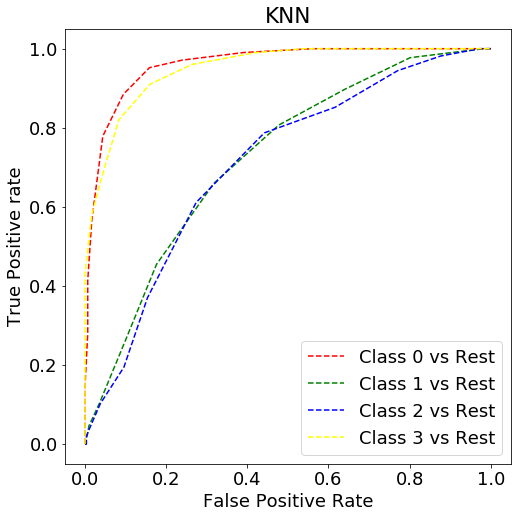

In [599]:
y_prob_pred = knn_best.predict_proba(X_test)
y_test1.append(y_test)
y_prob_pred1.append(y_prob_pred)
roc_plot(y_test,y_prob_pred,'KNN')

# Decision Trees

In [600]:
from sklearn.tree import DecisionTreeClassifier,plot_tree
dt = DecisionTreeClassifier(random_state = 0)

In [601]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [602]:
dt.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [603]:
dt.score(X_test,y_test)

0.85

In [604]:
params = {
        'criterion' : ['gini', 'entropy'],
        'splitter' : ['best','random'],
        'max_depth' : [5,10,20,30,40,None],
        'min_samples_split' : Integer(2,7),
        'min_samples_leaf' : Integer(1,5),
        'max_features' : [None,'auto', 'sqrt', 'log2'],
        'random_state' : [0]
}

In [605]:
bayes_search = BayesSearchCV(estimator=dt, 
                           search_spaces=params, 
                           cv=3, n_jobs=-1, scoring = "accuracy")

In [606]:
bayes_search.fit(X_train, y_train)

BayesSearchCV(cv=3, error_score='raise',
              estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                               criterion='gini', max_depth=None,
                                               max_features=None,
                                               max_leaf_nodes=None,
                                               min_impurity_decrease=0.0,
                                               min_impurity_split=None,
                                               min_samples_leaf=1,
                                               min_samples_split=2,
                                               min_weight_fraction_leaf=0.0,
                                               presort='deprecated',
                                               random_state=0,
                                               splitter='best'),
              fit_p...
              scoring='accuracy',
              search_spaces={'criterion': ['gini', 

In [607]:
bayes_search.best_params_

OrderedDict([('criterion', 'gini'),
             ('max_depth', None),
             ('max_features', None),
             ('min_samples_leaf', 5),
             ('min_samples_split', 7),
             ('random_state', 0),
             ('splitter', 'best')])

In [608]:
bayes_search.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [609]:
dt_best = bayes_search.best_estimator_

In [610]:
dt_best.score(X_test,y_test)

0.85

In [611]:
confusion_matrix(y_test,dt_best.predict(X_test))

array([[94, 10,  0,  0],
       [ 6, 73,  9,  0],
       [ 0,  9, 92,  7],
       [ 0,  0, 19, 81]], dtype=int64)

In [612]:
print(classification_report(y_test,dt_best.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92       104
         1.0       0.79      0.83      0.81        88
         2.0       0.77      0.85      0.81       108
         3.0       0.92      0.81      0.86       100

    accuracy                           0.85       400
   macro avg       0.86      0.85      0.85       400
weighted avg       0.86      0.85      0.85       400



In [613]:
store_metrics(dt,dt_best,X_train,y_train,X_test,y_test)
print_metrics(1)

For training data:
	 Accuracy : 	 94.81%
	 Precision : 	 0.949
	 Recall : 	 0.948
	 AUC_ROC : 	 0.997
For testing data: 
	 Accuracy : 	 85.0%
	 Precision : 	 0.856
	 Recall : 	 0.85
	 AUC_ROC : 	 0.936


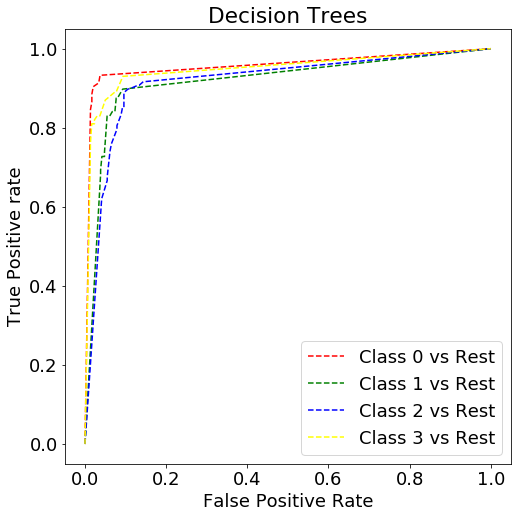

In [614]:
y_prob_pred = dt_best.predict_proba(X_test)
y_test1.append(y_test)
y_prob_pred1.append(y_prob_pred)
roc_plot(y_test,y_prob_pred,'Decision Trees')

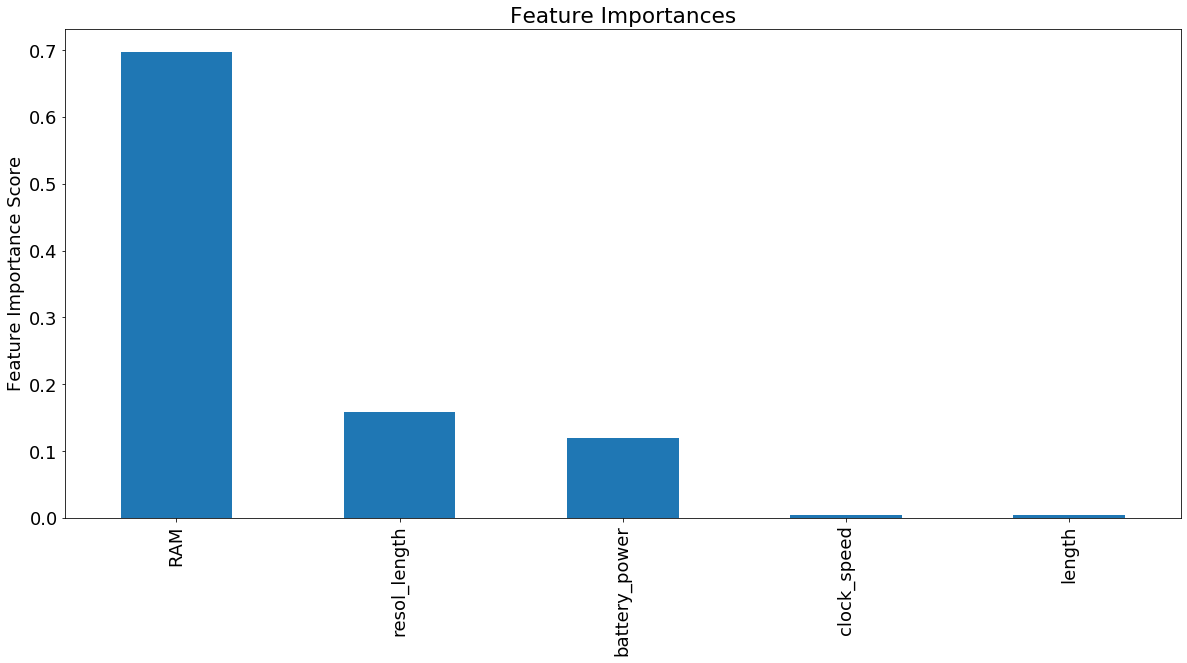

In [615]:
printFeatureImportance(dt_best)

# Logistic Regression

In [616]:
from sklearn.linear_model import LogisticRegression

In [617]:
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)

In [618]:
lr = LogisticRegression(random_state=0)

In [619]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [620]:
lr.score(X_test,y_test)

0.8925

In [621]:
params = {
    'C' : [0.001,0.01,0.1,1,10],
    'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

In [622]:
bayes_search = BayesSearchCV(estimator=lr, 
                           search_spaces=params, 
                           cv=3, n_jobs=-1, scoring = "accuracy")

In [623]:
bayes_search.fit(X_train, y_train)

BayesSearchCV(cv=3, error_score='raise',
              estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                           fit_intercept=True,
                                           intercept_scaling=1, l1_ratio=None,
                                           max_iter=100, multi_class='auto',
                                           n_jobs=None, penalty='l2',
                                           random_state=0, solver='lbfgs',
                                           tol=0.0001, verbose=0,
                                           warm_start=False),
              fit_params=None, iid='deprecated', n_iter=50, n_jobs=-1,
              n_points=1, optimizer_kwargs=None, pre_dispatch='2*n_jobs',
              random_state=None, refit=True, return_train_score=False,
              scoring='accuracy',
              search_spaces={'C': [0.001, 0.01, 0.1, 1, 10],
                             'solver': ['newton-cg', 'lbfgs', 'liblinear',


In [624]:
bayes_search.best_params_

OrderedDict([('C', 10.0), ('solver', 'saga')])

In [625]:
bayes_search.best_estimator_

LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [626]:
lr_best = bayes_search.best_estimator_

In [627]:
lr_best.score(X_test,y_test)

0.93

In [628]:
confusion_matrix(y_test,lr_best.predict(X_test))

array([[97,  7,  0,  0],
       [ 2, 85,  1,  0],
       [ 0,  4, 96,  8],
       [ 0,  0,  6, 94]], dtype=int64)

In [629]:
print(classification_report(y_test,lr_best.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.98      0.93      0.96       104
         1.0       0.89      0.97      0.92        88
         2.0       0.93      0.89      0.91       108
         3.0       0.92      0.94      0.93       100

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



In [630]:
store_metrics(lr,lr_best,X_train,y_train,X_test,y_test)
print_metrics(2)

For training data:
	 Accuracy : 	 94.99%
	 Precision : 	 0.95
	 Recall : 	 0.95
	 AUC_ROC : 	 0.997
For testing data: 
	 Accuracy : 	 93.0%
	 Precision : 	 0.932
	 Recall : 	 0.93
	 AUC_ROC : 	 0.996


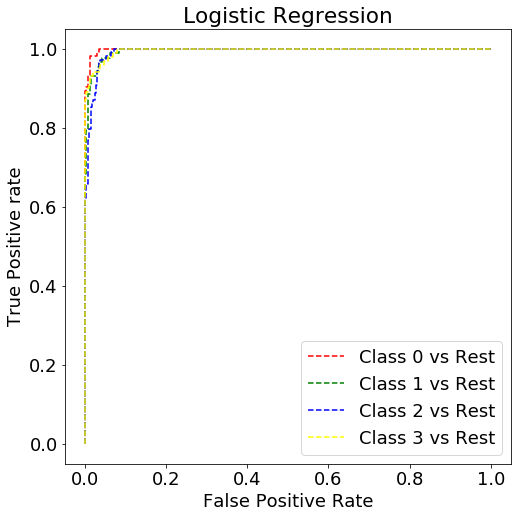

In [631]:
y_prob_pred = lr_best.predict_proba(X_test)
y_test1.append(y_test)
y_prob_pred1.append(y_prob_pred)
roc_plot(y_test,y_prob_pred,'Logistic Regression')

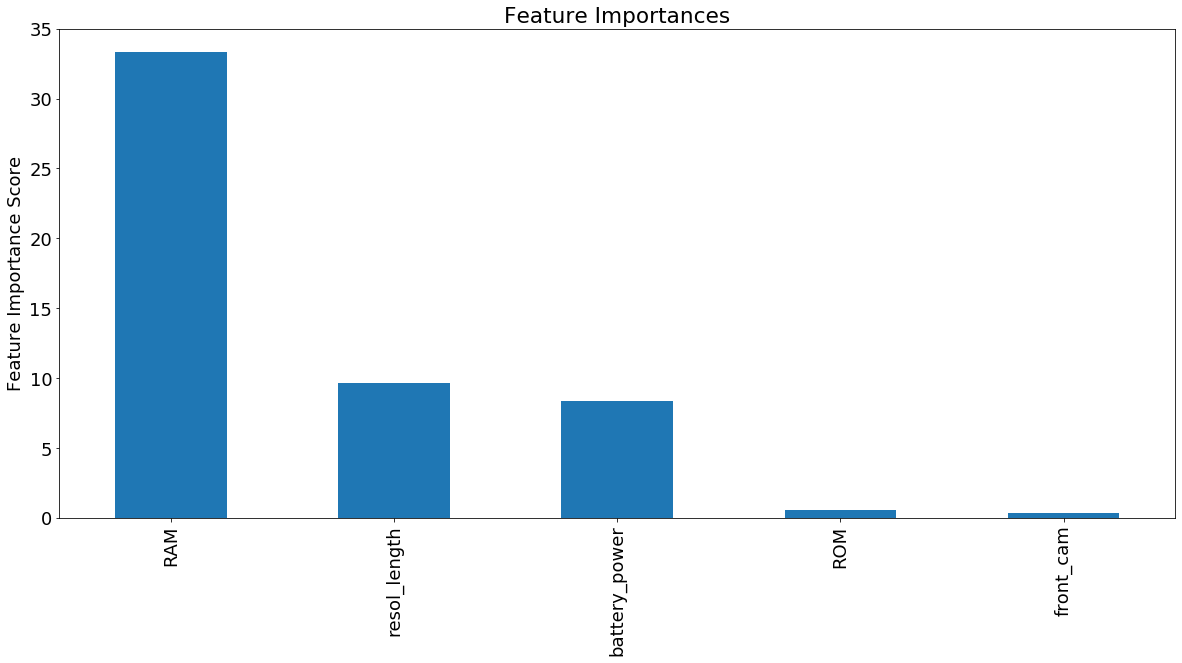

In [632]:
printFeatureImportance(lr_best)

# Random Forest

In [633]:
from sklearn.ensemble import RandomForestClassifier

In [634]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [635]:
rf = RandomForestClassifier(random_state = 0)

In [636]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [637]:
rf.score(X_test, y_test)

0.865

In [638]:
params = {
    'n_estimators' : list(range(100,1501,200)),
    'min_samples_leaf' : list(range(1,32,6)),
    'min_samples_split' : list(range(2,5)),
    'criterion' : ['gini','entropy'],
    'max_features' : ['auto','sqrt','log2'],
    'max_samples' : Real(0.00001,0.999)
}

In [639]:
bayes_search = BayesSearchCV(estimator=rf, 
                           search_spaces=params, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "accuracy")

In [640]:
bayes_search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


BayesSearchCV(cv=3, error_score='raise',
              estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                               class_weight=None,
                                               criterion='gini', max_depth=None,
                                               max_features='auto',
                                               max_leaf_nodes=None,
                                               max_samples=None,
                                               min_impurity_decrease=0.0,
                                               min_impurity_split=None,
                                               min_samples_leaf=1,
                                               min_samples_split=2,
                                               min_weight_fraction_leaf=0.0,
                                               n_estimators=100, n_jobs=...
              random_state=None, refit=True, return_train_score=False,
              scoring='accur

In [641]:
bayes_search.best_params_

OrderedDict([('criterion', 'entropy'),
             ('max_features', 'log2'),
             ('max_samples', 0.5542147246421827),
             ('min_samples_leaf', 1),
             ('min_samples_split', 2),
             ('n_estimators', 100)])

In [642]:
bayes_search.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=0.5542147246421827,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [643]:
rf_best = bayes_search.best_estimator_

rf_best.score(X_test,y_test)

0.875

In [644]:
confusion_matrix(y_test,rf_best.predict(X_test))

array([[99,  5,  0,  0],
       [ 6, 76,  6,  0],
       [ 0, 11, 84, 13],
       [ 0,  0,  9, 91]], dtype=int64)

In [645]:
print(classification_report(y_test,rf_best.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95       104
         1.0       0.83      0.86      0.84        88
         2.0       0.85      0.78      0.81       108
         3.0       0.88      0.91      0.89       100

    accuracy                           0.88       400
   macro avg       0.87      0.88      0.87       400
weighted avg       0.87      0.88      0.87       400



In [646]:
store_metrics(rf,rf_best,X_train,y_train,X_test,y_test)
print_metrics(3)

For training data:
	 Accuracy : 	 99.94%
	 Precision : 	 0.999
	 Recall : 	 0.999
	 AUC_ROC : 	 1.0
For testing data: 
	 Accuracy : 	 87.5%
	 Precision : 	 0.875
	 Recall : 	 0.875
	 AUC_ROC : 	 0.98


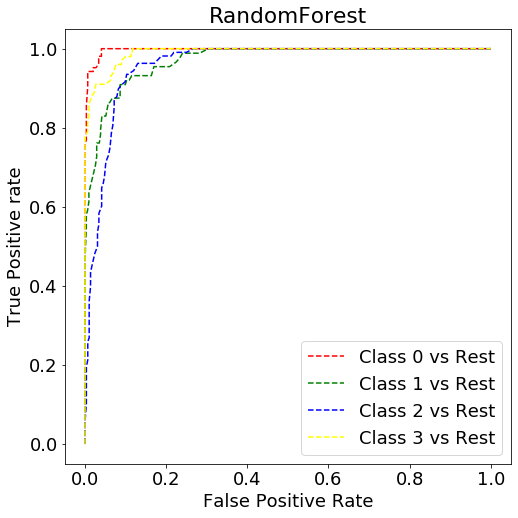

In [647]:
y_prob_pred = rf_best.predict_proba(X_test)
y_test1.append(y_test)
y_prob_pred1.append(y_prob_pred)
roc_plot(y_test,y_prob_pred,'RandomForest')

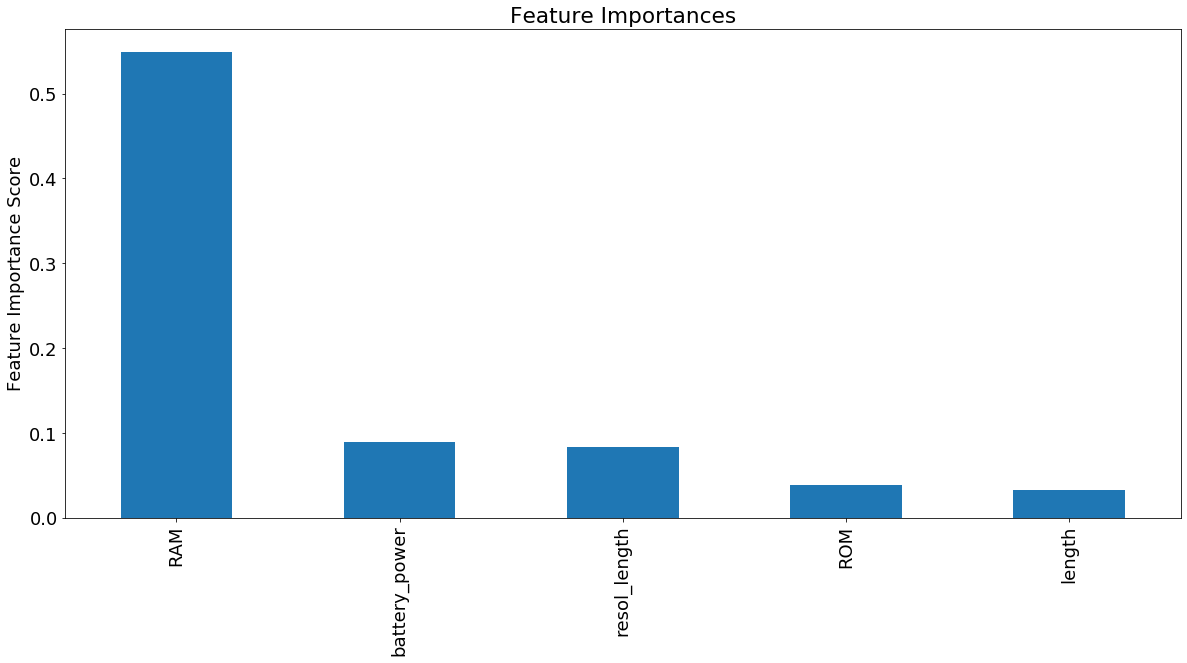

In [648]:
printFeatureImportance(rf_best)

# AdaBoost

In [649]:
from sklearn.ensemble import AdaBoostClassifier

In [650]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [651]:
ab = AdaBoostClassifier(base_estimator = dt_best, learning_rate = 1, random_state = 0)

In [652]:
ab.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=5,
                                                         min_samples_split=7,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                       

In [653]:
ab.score(X_test,y_test)

0.8975

In [654]:
params = {
    'learning_rate' : [0.1,1,10],
    'n_estimators' : list(range(50,251,25))
}

In [655]:
bayes_search = BayesSearchCV(estimator=ab, 
                           search_spaces=params, 
                           cv=3, n_jobs=-1, verbose=1, scoring = 'accuracy')

In [656]:
bayes_search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished


BayesSearchCV(cv=3, error_score='raise',
              estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                           base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                 class_weight=None,
                                                                                 criterion='gini',
                                                                                 max_depth=None,
                                                                                 max_features=None,
                                                                                 max_leaf_nodes=None,
                                                                                 min_impurity_decrease=0.0,
                                                                                 min_impurity_split=None,
                                                                                 min_sa

In [657]:
bayes_search.best_params_

OrderedDict([('learning_rate', 0.1), ('n_estimators', 50)])

In [658]:
bayes_search.best_estimator_

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=5,
                                                         min_samples_split=7,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                       

In [659]:
ab_best = bayes_search.best_estimator_
ab_best.score(X_test, y_test)

0.915

In [660]:
confusion_matrix(y_test,ab_best.predict(X_test))

array([[98,  6,  0,  0],
       [ 5, 80,  3,  0],
       [ 0,  5, 93, 10],
       [ 0,  0,  5, 95]], dtype=int64)

In [661]:
print(classification_report(y_test,ab_best.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.95      0.94      0.95       104
         1.0       0.88      0.91      0.89        88
         2.0       0.92      0.86      0.89       108
         3.0       0.90      0.95      0.93       100

    accuracy                           0.92       400
   macro avg       0.91      0.92      0.91       400
weighted avg       0.92      0.92      0.91       400



In [662]:
store_metrics(ab,ab_best,X_train,y_train,X_test,y_test)
print_metrics(4)

For training data:
	 Accuracy : 	 100.0%
	 Precision : 	 1.0
	 Recall : 	 1.0
	 AUC_ROC : 	 1.0
For testing data: 
	 Accuracy : 	 91.5%
	 Precision : 	 0.916
	 Recall : 	 0.915
	 AUC_ROC : 	 0.989


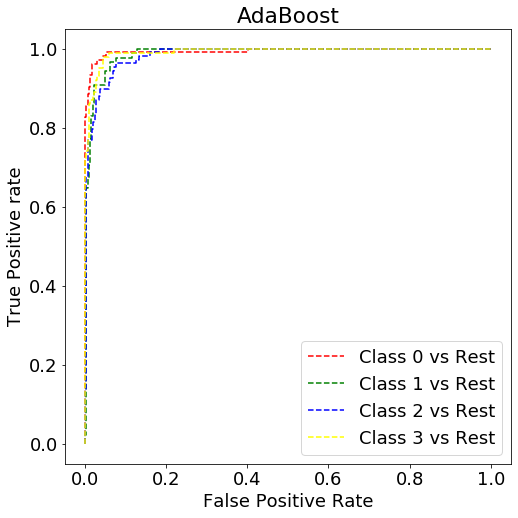

In [663]:
y_prob_pred = ab_best.predict_proba(X_test)
roc_plot(y_test,y_prob_pred,'AdaBoost')

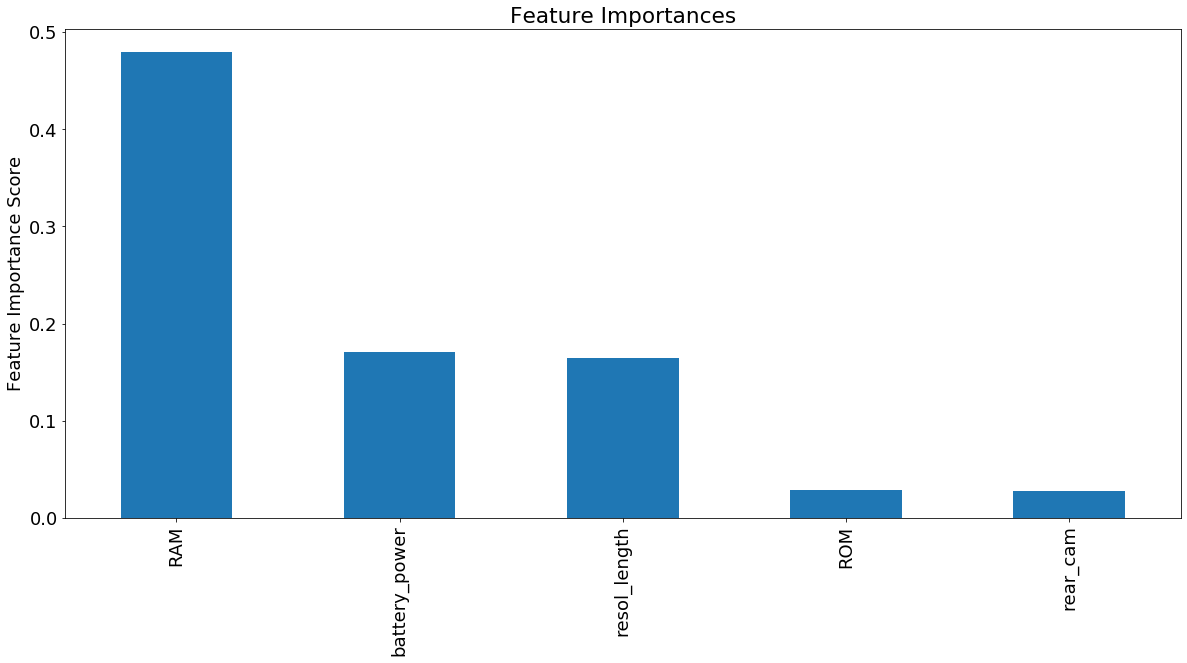

In [664]:
printFeatureImportance(ab_best)

# Gradient Boost

In [665]:
from sklearn.ensemble import GradientBoostingClassifier

In [666]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [667]:
gb = GradientBoostingClassifier(random_state = 0)

In [668]:
gb.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [669]:
gb.score(X_test,y_test)

0.895

In [670]:
params = {'n_estimators' : list(range(100,1001,50)),
          'max_depth' : list(range(1,11)),
          'learning_rate' : Real(0.00001,1),
          'max_features' : ['sqrt','auto',None],
          'min_samples_split' : list(range(2,6)),
          }

In [671]:
bayes_search = BayesSearchCV(estimator=gb, 
                           search_spaces=params, 
                           cv=3, n_jobs=-1, verbose=1, scoring = "accuracy")

In [672]:
bayes_search.fit(X_train,y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.9s finished


BayesSearchCV(cv=3, error_score='raise',
              estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                   criterion='friedman_mse',
                                                   init=None, learning_rate=0.1,
                                                   loss='deviance', max_depth=3,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                                                   n_iter...
    

In [673]:
bayes_search.best_params_

OrderedDict([('learning_rate', 0.5375323323594977),
             ('max_depth', 1),
             ('max_features', None),
             ('min_samples_split', 5),
             ('n_estimators', 1000)])

In [674]:
bayes_search.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.5375323323594977, loss='deviance',
                           max_depth=1, max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=5,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [675]:
gb_best = bayes_search.best_estimator_
gb_best.score(X_test,y_test)

0.91

In [676]:
confusion_matrix(y_test,gb_best.predict(X_test))

array([[97,  7,  0,  0],
       [ 5, 79,  4,  0],
       [ 0,  4, 97,  7],
       [ 0,  0,  9, 91]], dtype=int64)

In [677]:
print(classification_report(y_test,gb_best.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94       104
         1.0       0.88      0.90      0.89        88
         2.0       0.88      0.90      0.89       108
         3.0       0.93      0.91      0.92       100

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400



In [678]:
store_metrics(gb,gb_best,X_train,y_train,X_test,y_test)
print_metrics(5)

For training data:
	 Accuracy : 	 100.0%
	 Precision : 	 1.0
	 Recall : 	 1.0
	 AUC_ROC : 	 1.0
For testing data: 
	 Accuracy : 	 91.0%
	 Precision : 	 0.911
	 Recall : 	 0.91
	 AUC_ROC : 	 0.991


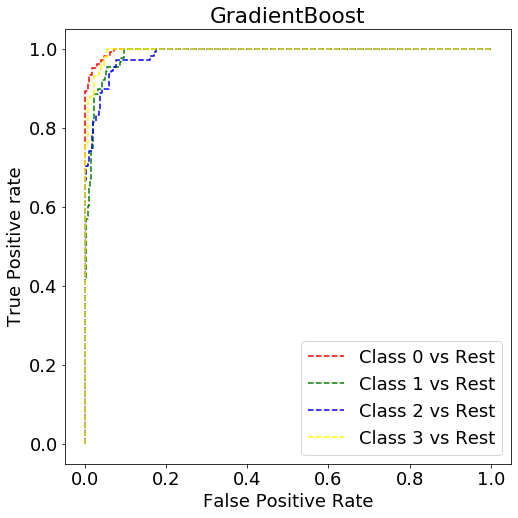

In [679]:
y_prob_pred = gb_best.predict_proba(X_test)
y_test1.append(y_test)
y_prob_pred1.append(y_prob_pred)
roc_plot(y_test,y_prob_pred,'GradientBoost')

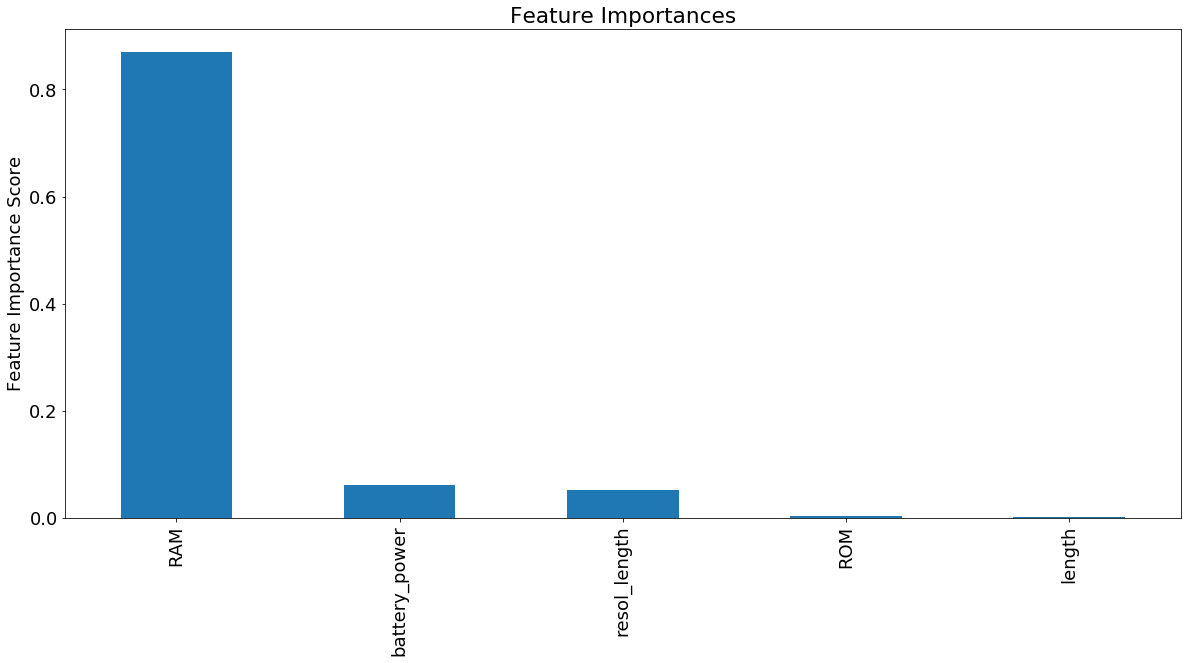

In [680]:
printFeatureImportance(gb_best)

# XG Boost

In [681]:
from xgboost import XGBClassifier

In [682]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [683]:
xg = XGBClassifier(random_state = 0)

In [684]:
xg.fit(X_train,y_train)

[11:27:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [685]:
xg.score(X_test,y_test)

0.9125

In [686]:
params = {
    'booster' : ['gbtree', 'gblinear','dart'],
    'learning_rate' : Real(0.0001,1),
    'n_estimators' : list(range(100,501,50)),
    'gamma' : list(range(10,51,10)),
    'min_child_weight' : list(range(5,26,5)),
    'lambda' :Integer(1,5) ,
    'alpha' : Integer(0,4)
}

In [687]:
bayes_search = BayesSearchCV(estimator=xg, 
                           search_spaces=params, 
                           cv=3, n_jobs=-1,verbose=1, scoring = 'accuracy')

In [688]:
bayes_search.fit(X_train,y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   16.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.1min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.1min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  1.2min finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.2s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.3s finished


[11:32:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "colsample_bylevel", "colsample_bynode", "colsample_bytree", "gamma", "interaction_constraints", "max_delta_step", "max_depth", "min_child_weight", "monotone_constraints", "num_parallel_tree", "predictor", "subsample", "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:32:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


BayesSearchCV(cv=3, error_score='raise',
              estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                      colsample_bylevel=1, colsample_bynode=1,
                                      colsample_bytree=1,
                                      enable_categorical=False, gamma=0,
                                      gpu_id=-1, importance_type=None,
                                      interaction_constraints='',
                                      learning_rate=0.300000012,
                                      max_delta_step=0, max_depth=6,
                                      min_child_weight=1, missing=nan,
                                      monotone_constraints...
              search_spaces={'alpha': Integer(low=0, high=4, prior='uniform', transform='normalize'),
                             'booster': ['gbtree', 'gblinear', 'dart'],
                             'gamma': [10, 20, 30, 40, 50],
                             'lambda': 

In [689]:
bayes_search.best_params_

OrderedDict([('alpha', 1),
             ('booster', 'gblinear'),
             ('gamma', 20),
             ('lambda', 5),
             ('learning_rate', 1.0),
             ('min_child_weight', 5),
             ('n_estimators', 500)])

In [690]:
xg_best = bayes_search.best_estimator_
xg_best.score(X_test, y_test)

0.9275

In [691]:
confusion_matrix(y_test,xg_best.predict(X_test))

array([[97,  7,  0,  0],
       [ 2, 84,  2,  0],
       [ 0,  4, 94, 10],
       [ 0,  0,  4, 96]], dtype=int64)

In [692]:
print(classification_report(y_test,xg_best.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.98      0.93      0.96       104
         1.0       0.88      0.95      0.92        88
         2.0       0.94      0.87      0.90       108
         3.0       0.91      0.96      0.93       100

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



In [693]:
store_metrics(xg,xg_best,X_train,y_train,X_test,y_test)
print_metrics(6)

For training data:
	 Accuracy : 	 94.49%
	 Precision : 	 0.945
	 Recall : 	 0.945
	 AUC_ROC : 	 0.996
For testing data: 
	 Accuracy : 	 92.75%
	 Precision : 	 0.929
	 Recall : 	 0.928
	 AUC_ROC : 	 0.996


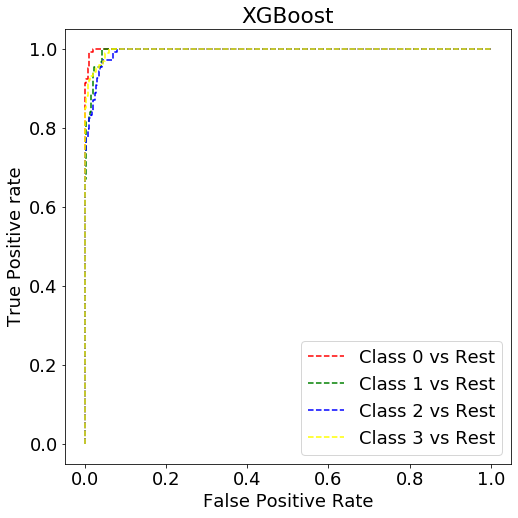

In [694]:
y_prob_pred = xg_best.predict_proba(X_test)
y_test1.append(y_test)
y_prob_pred1.append(y_prob_pred)
roc_plot(y_test,y_prob_pred,'XGBoost')

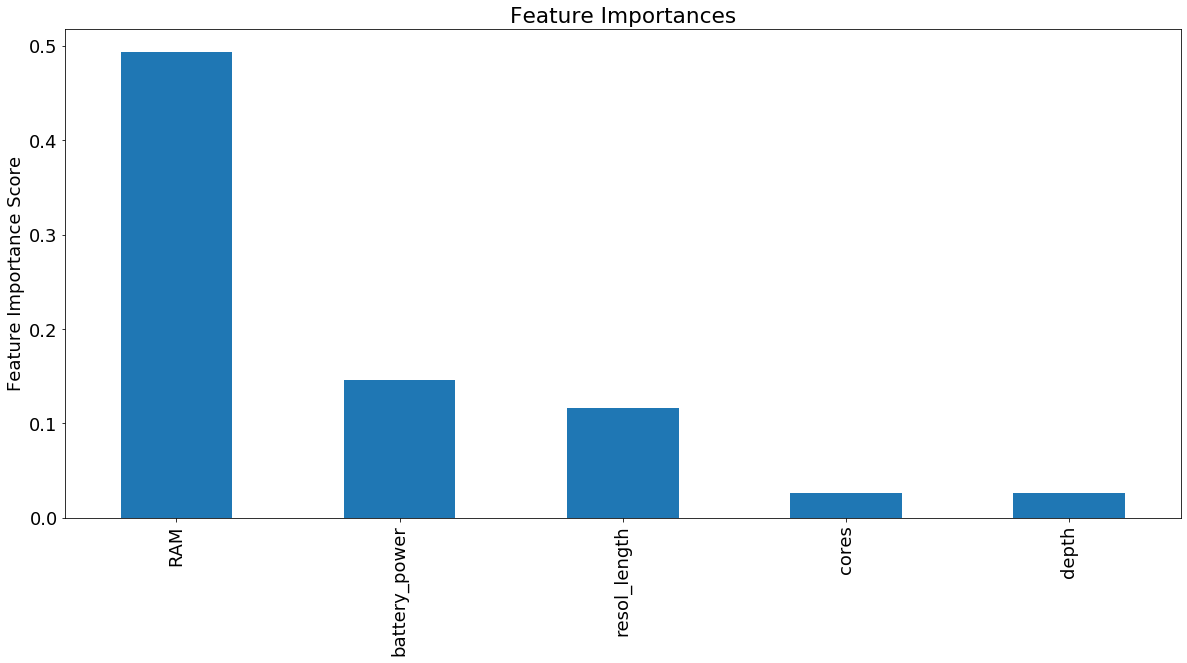

In [695]:
printFeatureImportance(xg)

# Model Comparision

# Final DataFrame containing Accuracy, Precision, Recall, Roc_Auc scores for different algorithms.
Both for before and after tuning.

In [696]:
cols = pd.MultiIndex.from_tuples((('Train Data', 'Accuracy'),('Train Data', 'Precision'),('Train Data', 'Recall'),('Train Data', 'AUC_ROC'),('Test Data', 'Accuracy'),('Test Data', 'Precision'),('Test Data', 'Recall'),('Test Data', 'AUC_ROC')))
before_tuning_df = pd.DataFrame(list(zip(BeforeTuning_train['Accuracy'],BeforeTuning_train['Precision'],
                                 BeforeTuning_train['Recall'],BeforeTuning_train['AUC_ROC'],
                                 BeforeTuning_test['Accuracy'],BeforeTuning_test['Precision'],
                                 BeforeTuning_test['Recall'],BeforeTuning_test['AUC_ROC'])),
                        columns = cols, index = index)

In [697]:
before_tuning_df

Train Data                          Test Data                         
                      Accuracy Precision Recall AUC_ROC  Accuracy Precision Recall AUC_ROC
KNN                      67.9%     0.685  0.679   0.869     59.0%     0.614  0.590   0.837
Decision Tree           100.0%     1.000  1.000   1.000     85.0%     0.854  0.850   0.900
Logistic Regression     92.68%     0.927  0.927   0.992    89.25%     0.894  0.892   0.990
Random Forest           100.0%     1.000  1.000   1.000     86.5%     0.865  0.865   0.981
AdaBoost                100.0%     1.000  1.000   1.000    89.75%     0.900  0.898   0.986
Gradient Boost          99.69%     0.997  0.997   1.000     89.5%     0.896  0.895   0.988
XGBoost                 100.0%     1.000  1.000   1.000    91.25%     0.913  0.912   0.992

In [698]:
cols = pd.MultiIndex.from_tuples((('Train Data', 'Accuracy'),('Train Data', 'Precision'),('Train Data', 'Recall'),('Train Data', 'AUC_ROC'),('Test Data', 'Accuracy'),('Test Data', 'Precision'),('Test Data', 'Recall'),('Test Data', 'AUC_ROC')))
after_tuning_df = pd.DataFrame(list(zip(AfterTuning_train['Accuracy'],AfterTuning_train['Precision'],
                                 AfterTuning_train['Recall'],AfterTuning_train['AUC_ROC'],
                                 AfterTuning_test['Accuracy'],AfterTuning_test['Precision'],
                                 AfterTuning_test['Recall'],AfterTuning_test['AUC_ROC'])),
                        columns = cols, index = index)

In [699]:
after_tuning_df

Train Data                          Test Data                         
                      Accuracy Precision Recall AUC_ROC  Accuracy Precision Recall AUC_ROC
KNN                     66.52%     0.668  0.665   0.868    61.75%     0.637  0.618   0.838
Decision Tree           94.81%     0.949  0.948   0.997     85.0%     0.856  0.850   0.936
Logistic Regression     94.99%     0.950  0.950   0.997     93.0%     0.932  0.930   0.996
Random Forest           99.94%     0.999  0.999   1.000     87.5%     0.875  0.875   0.980
AdaBoost                100.0%     1.000  1.000   1.000     91.5%     0.916  0.915   0.989
Gradient Boost          100.0%     1.000  1.000   1.000     91.0%     0.911  0.910   0.991
XGBoost                 94.49%     0.945  0.945   0.996    92.75%     0.929  0.928   0.996

## F1 scores and Roc-Auc Curves for different classes for different Algorithms.

In [700]:
cols = pd.MultiIndex.from_tuples(((' ', 'Class-0'),(' ', 'Class-1'),('Accuracy', 'Class-2'),(' ', 'Class-3'),(' ','Overall')))
Accuray_df = pd.DataFrame(list(zip(Accuracy['Class-0'],Accuracy['Class-1'],Accuracy['Class-2'],Accuracy['Class-3'],Accuracy['Overall'])),
                        columns = cols, index = index)

In [701]:
Accuray_df

Accuracy                 
                     Class-0  Class-1  Class-2  Class-3 Overall
KNN                  71.82 %  44.55 %  52.43 %  84.42 %  61.75%
Decision Tree         94.0 %  79.35 %  76.67 %  92.05 %   85.0%
Logistic Regression  97.98 %  88.54 %   93.2 %  92.16 %   93.0%
Random Forest        94.29 %  82.61 %  84.85 %   87.5 %   87.5%
AdaBoost             95.15 %  87.91 %  92.08 %  90.48 %   91.5%
Gradient Boost        95.1 %  87.78 %  88.18 %  92.86 %   91.0%
XGBoost              97.98 %  88.42 %   94.0 %  90.57 %  92.75%

In [702]:
cols = pd.MultiIndex.from_tuples(((' ', 'Class-0'),(' ', 'Class-1'),('F1_score', 'Class-2'),(' ', 'Class-3'),(' ','Overall')))
f1_score_df = pd.DataFrame(list(zip(F1_score['Class-0'],F1_score['Class-1'],F1_score['Class-2'],F1_score['Class-3'],F1_score['Overall'])),
                        columns = cols, index = index)

In [704]:
f1_score_df

F1_score                  
                    Class-0 Class-1  Class-2 Class-3   Overall
KNN                    0.74    0.49     0.51    0.73  0.622666
Decision Tree          0.92    0.81     0.81    0.86  0.851373
Logistic Regression    0.96    0.92     0.91    0.93  0.930094
Random Forest          0.95    0.84     0.81    0.89  0.874263
AdaBoost               0.95    0.89     0.89    0.93  0.914826
Gradient Boost         0.94    0.89     0.89    0.92  0.910208
XGBoost                0.96    0.92     0.90    0.93  0.927488

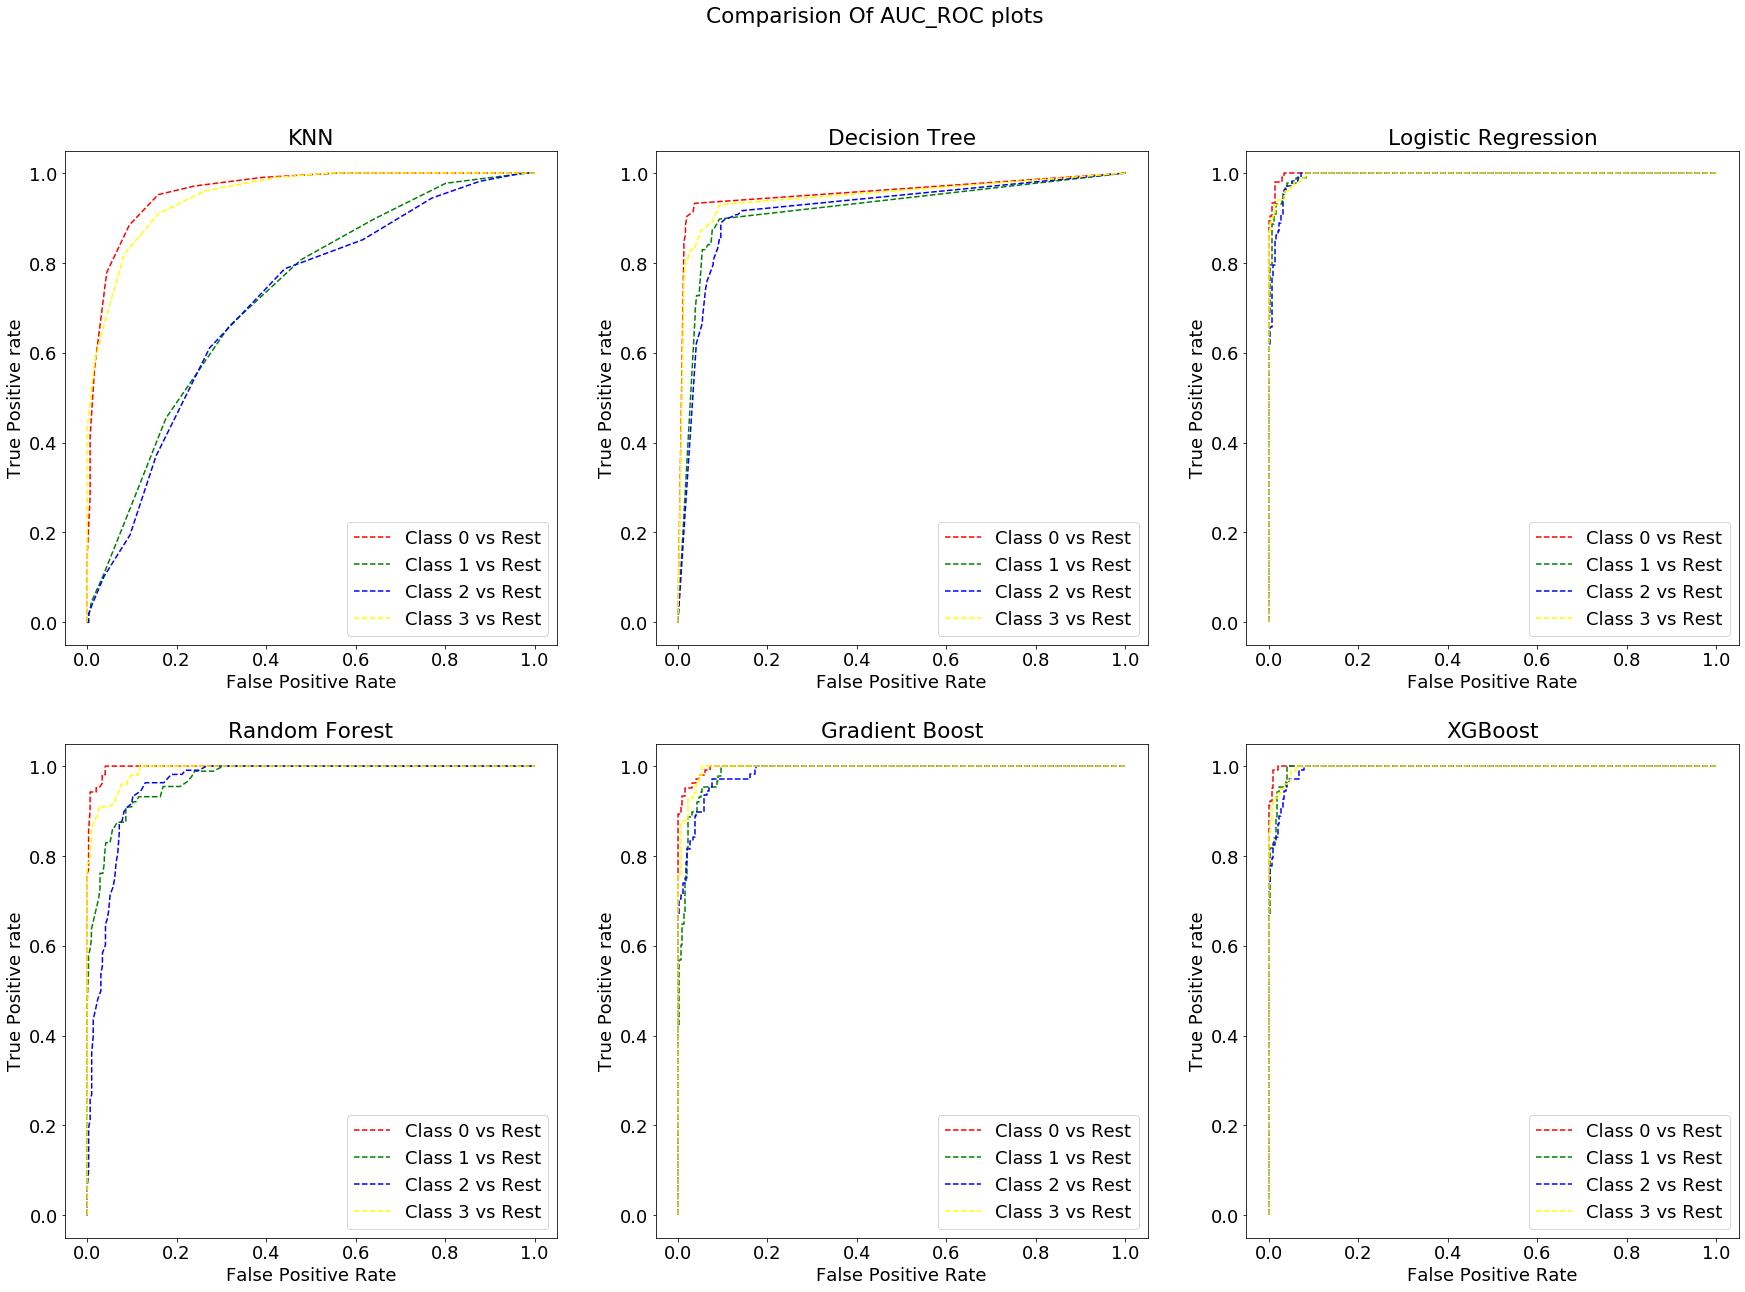

In [705]:
index1 = ['KNN', 'Decision Tree','Logistic Regression', 'Random Forest', 'Gradient Boost', 'XGBoost']
fig, axes = plt.subplots(2, 3,figsize=(30,20))
fig.suptitle('Comparision Of AUC_ROC plots')
z=0
for i in range(2):
    for j in range(3):
        roc_plot(y_test1[z],y_prob_pred1[z],index1[z],i,j,1)
        z+=1